# Visualizing latent space with t-SNE

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from scipy.stats import ttest_ind
from scipy.stats import bartlett
import seaborn as sns
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *

In [2]:
# %%capture
debug = False
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',modality='t2',num_samples=100 if debug else None)
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',modality='t2',num_samples=100 if debug else None)
brats_train_loader, brats_test_loader, brats_val_loader = get_dataloader('brats',modality='t2',num_samples=100 if debug else None)

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [3]:
# %%capture 
model_dhcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/dHCP/best.pth')
model_hcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/HCP/best.pth')
model_brats = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/BraTS/best.pth')
# model_dhcp = model_dhcp.cuda()
# model_hcp = model_hcp.cuda()
# model_brats = model_brats.cuda()
model_dhcp.eval()
model_hcp.eval()
model_brats.eval()
model = model_dhcp

In [4]:
# dHCP Model
latent_dhcp_dhcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_train.pt')
latent_hcp_dhcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_train.pt')
latent_brats_dhcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_dhcp_train.pt')
latent_dhcp_dhcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_val.pt')
latent_hcp_dhcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_val.pt')
latent_brats_dhcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_dhcp_val.pt')
latent_brown_dhcp = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown_dhcp.pt')
# HCP Model
latent_dhcp_hcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_hcp_train.pt')
latent_hcp_hcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_hcp_train.pt')
latent_brats_hcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_hcp_train.pt')
latent_dhcp_hcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_hcp_val.pt')
latent_hcp_hcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_hcp_val.pt')
latent_brats_hcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_hcp_val.pt')
latent_brown_hcp = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown_hcp.pt')
# BraTS Model
latent_dhcp_brats_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_brats_train.pt')
latent_hcp_brats_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_brats_train.pt')
latent_brats_brats_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_train.pt')
latent_dhcp_brats_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_brats_val.pt')
latent_hcp_brats_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_brats_val.pt')
latent_brats_brats_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_val.pt')
latent_brown_brats = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown_brats.pt')

In [5]:
divergences_innate = []
divergences_innate.append(get_innate_divergences(latent_dhcp_dhcp_val,latent_dhcp_dhcp_train))
divergences_innate.append(get_innate_divergences(latent_hcp_hcp_val,latent_hcp_hcp_train))
divergences_innate.append(get_innate_divergences(latent_brats_brats_val,latent_brats_brats_train))

In [ ]:
# divergences_innate = np.zeros(3)
# divergences_innate[0] = SamplesLoss("sinkhorn")(latent_brats_brats_val.flatten(start_dim=1), latent_brats_brats_train.flatten(start_dim=1))
# divergences_innate[1] = SamplesLoss("sinkhorn")(latent_hcp_hcp_val.flatten(start_dim=1), latent_hcp_hcp_train.flatten(start_dim=1))
# divergences_innate[2] = SamplesLoss("sinkhorn")(latent_dhcp_dhcp_val.flatten(start_dim=1), latent_dhcp_dhcp_train.flatten(start_dim=1))
# latents = [latent_brats_brats_train,latent_hcp_hcp_train,latent_dhcp_dhcp_train]

In [ ]:
divergences_innate_1vsall = np.zeros(latent_dhcp_dhcp_val.shape[0])
divergences_innate_1vsavg = np.zeros(latent_dhcp_dhcp_val.shape[0])
divergences_innate_1vs1 = np.zeros((latent_dhcp_dhcp_val.shape[0],latent_dhcp_dhcp_train.shape[0]))
for idx,x in enumerate(latent_dhcp_dhcp_val):
    divergences_innate_1vsall[idx] = SamplesLoss("sinkhorn")(x.flatten(start_dim=0).unsqueeze(0), latent_dhcp_dhcp_train.flatten(start_dim=1)) #(1,320000) vs (250,320000)
    divergences_innate_1vsavg[idx] = SamplesLoss("sinkhorn")(x.flatten(start_dim=0).unsqueeze(0), latent_dhcp_dhcp_train.flatten(start_dim=1).mean(dim=0).unsqueeze(0)) #(1,320000) vs (1,320000)

In [ ]:
print(divergences_innate_1vsall)
print(divergences_innate_1vsavg)
print(divergences_innate_1vs1.mean(1))

In [ ]:
plt.scatter(divergences_innate_1vs1.mean(1),divergences_innate_1vsall)

In [ ]:
plt.scatter(divergences_innate_1vs1.mean(1),divergences_innate_1vsavg)

In [ ]:

plt.scatter(divergences_innate_1vsall,divergences_innate_1vsavg)

In [ ]:
print(divergences_innate_1vsall)
print(divergences_innate_1vsavg)

# t-SNE

## dHCP Model

In [ ]:
cursors = [0]
cursors.append(cursors[-1] + latent_dhcp_dhcp_train.shape[0])
cursors.append(cursors[-1] + latent_dhcp_dhcp_val.shape[0])
cursors.append(cursors[-1] + latent_hcp_dhcp_train.shape[0])
cursors.append(cursors[-1] + latent_hcp_dhcp_val.shape[0])
cursors.append(cursors[-1] + latent_brats_dhcp_train.shape[0])
cursors.append(cursors[-1] + latent_brats_dhcp_val.shape[0])
cursors.append(cursors[-1] + latent_brown_dhcp.shape[0])
labels = torch.zeros(cursors[-1])
labels[cursors[0]:cursors[1]] = 0
labels[cursors[1]:cursors[2]] = 1
labels[cursors[2]:cursors[3]] = 2
labels[cursors[3]:cursors[4]] = 3
labels[cursors[4]:cursors[5]] = 4
labels[cursors[5]:cursors[6]] = 5
labels[cursors[6]:cursors[7]] = 6

In [ ]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("paper", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

# latent = torch.cat([latent_dhcp,latent_hcp,latent_brown],dim=0)
latent = torch.cat([latent_dhcp_dhcp_train,
                    latent_dhcp_dhcp_val,
                    latent_hcp_dhcp_train,
                    latent_hcp_dhcp_val,
                    latent_brats_dhcp_train,
                    latent_brats_dhcp_val,
                    latent_brown_dhcp],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
tsne = TSNE(n_components=2)
latent_embedded = tsne.fit_transform(latent)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(['dHCP on dHCP Model (Train)',
            'dHCP on dHCP Model (Val)',
            'HCP on dHCP Model (Train)',
            'HCP on dHCP Model (Val)',
            'BraTS on dHCP Model (Train)',
            'BraTS on dHCP Model (Val)',
            'Unseen Paediatric Images'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('figures/tsne.svg',bbox_inches='tight')

# Generate Latents

In [ ]:
images = []
image_tensors = []
landmarks_t1 = op.join('/media/hdd/dhcp/dhcp_hires', 'landmarks_t1.npy')
landmarks_t2 = op.join('/media/hdd/dhcp/dhcp_hires', 'landmarks_t2.npy')
landmarks_dict = {'image_t1':landmarks_t1,'image_t2':landmarks_t2}
t2_file_list = os.listdir('/media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/reg/')
t2_file_list = [os.path.join('/media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/reg/',f'%03d.nii.gz'%x) for x in range(len(t2_file_list))]
for t2_file in tqdm(t2_file_list,total=len(t2_file_list)):
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(image_t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        tio.transforms.HistogramStandardization(landmarks_dict),
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    shape = subject.image_t2.data.numpy()[0].shape
    lb = np.percentile(subject.image_t2.data.numpy(),1)
    bbox = get_bbox(subject.image_t2.data.numpy()[0],lb)
    transform_crop = tio.transforms.Crop((bbox[0], shape[0]-bbox[1], bbox[2], shape[1]-bbox[3], bbox[4], shape[2]-bbox[5]))
    subject = transform_crop(subject)
    edge_max = max(subject.image_t2.data.shape)
    padding = ((edge_max - subject.image_t2.data.shape[1]) // 2, 
                (edge_max - subject.image_t2.data.shape[2]) // 2,
                    (edge_max - subject.image_t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.image_t2.data.unsqueeze(0).float()
    image_tensor = torch.transpose(image_tensor,4,2).flip([4,3,2])
    image_tensors.append(image_tensor)

In [ ]:
display_multiplanar_center(image_tensors[9][0,0])
display_multiplanar_center(dhcp_test_loader.dataset.__getitem__(12)[1][0])
display_multiplanar_center(hcp_test_loader.dataset.__getitem__(12)[1][0])
display_multiplanar_center(brats_test_loader.dataset.__getitem__(12)[1][0])

## dHCP Model

In [ ]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_dhcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_train.pt')

latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_dhcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_train.pt')

latent_brats = []
for img,gt in tqdm(brats_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_dhcp,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_dhcp_train.pt')

latent_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_dhcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_val.pt')

latent_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_dhcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_val.pt')

latent_brats = []
for img,gt in tqdm(brats_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_dhcp,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_dhcp_val.pt')

latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model_dhcp,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown_dhcp.pt')

## HCP Model

In [ ]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_hcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_hcp_train.pt')
latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_hcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_hcp_train.pt')
latent_brats = []
for img,gt in tqdm(brats_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_hcp,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_hcp_train.pt')
latent_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_hcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_hcp_val.pt')
latent_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_hcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_hcp_val.pt')
latent_brats = []
for img,gt in tqdm(brats_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_hcp,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_hcp_val.pt')
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model_hcp,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown_hcp.pt')

## BraTS Model

In [ ]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_brats,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_brats_train.pt')
latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_brats,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_brats_train.pt')
latent_brats = []
for img,gt in tqdm(brats_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_brats,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_train.pt')
latent_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_brats,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_brats_val.pt')
latent_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_brats,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_brats_val.pt')
latent_brats = []
for img,gt in tqdm(brats_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_brats,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_val.pt')
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model_brats,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown_brats.pt')


# Pick best Brown

In [ ]:
div_min = np.Inf
divs = []
for i, img in enumerate(image_tensors):
    if i==13:
        continue
    img = img.cuda()
    with torch.no_grad():
        latent = kl_forward_latent(model_dhcp,img).cuda()
        latent_ = latent_dhcp_dhcp_train.cuda()
        latent = latent.flatten().unsqueeze(0)
        latent_ = latent_.flatten(start_dim=1)
        div_cur = SamplesLoss("sinkhorn")(latent, latent_)
        divs.append(div_cur.cpu().numpy())
        if div_cur <= div_min:
            div_min = div_cur
            pred = model_dhcp(img)
            display_multiplanar_center(img[0,0].detach().cpu().numpy())
            display_multiplanar_center(pred[0,0].detach().cpu().numpy())
            im_array = img[0,0].detach().cpu().numpy()
            im_pred_array = pred[0,0].detach().cpu().numpy()
            # Normalize with lowest 1% and highest value
            im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
            im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
            im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
            im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
            im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
            im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
            im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
            im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
            im_sag.save('figures/outputs/Best_Brown/sag.png')
            im_cor.save('figures/outputs/Best_Brown/cor.png')
            im_ax.save('figures/outputs/Best_Brown/ax.png')
            im_pred_sag.save('figures/outputs/Best_Brown/pred_sag.png')
            im_pred_cor.save('figures/outputs/Best_Brown/pred_cor.png')
            im_pred_ax.save('figures/outputs/Best_Brown/pred_ax.png')
            print(i)

In [ ]:
img = image_tensors[div_args[-1]].cuda()
print()
with torch.no_grad():
    pred = model_dhcp(img)
    display_multiplanar_center(img[0,0].detach().cpu().numpy())
    display_multiplanar_center(pred[0,0].detach().cpu().numpy())
    im_array = img[0,0].detach().cpu().numpy()
    im_pred_array = pred[0,0].detach().cpu().numpy()
    # Normalize with lowest 1% and highest value
    im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
    im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
    im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
    im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
    im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
    im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
    im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
    im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
    im_sag.save('figures/outputs/Best_Brown/sag.png')
    im_cor.save('figures/outputs/Best_Brown/cor.png')
    im_ax.save('figures/outputs/Best_Brown/ax.png')
    im_pred_sag.save('figures/outputs/Best_Brown/pred_sag.png')
    im_pred_cor.save('figures/outputs/Best_Brown/pred_cor.png')
    im_pred_ax.save('figures/outputs/Best_Brown/pred_ax.png')

# Schematic of Wasserstein

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
sns.plotting_context('talk')

x1 = np.random.normal(10, 5, 100)
x2 = np.random.normal(35, 5, 100)

x = np.stack((x1, x2), axis=1)

sns.displot(x, aspect=16/9, bins=12, kde=True)
plt.savefig('wasserstein_sched.svg',bbox_inches='tight')

# Quantitative Evaluation

### Collect statistics

In [6]:
def forward_with_latent(self, x):
    # encoder part
    encoders_features = []
    for encoder in self.encoders:
        x = encoder(x)
        # reverse the encoder outputs to be aligned with the decoder
        encoders_features.insert(0, x)
    latent = x.clone()
    # remove the last encoder's output from the list
    # !!remember: it's the 1st in the list
    encoders_features = encoders_features[1:]

    # decoder part
    for decoder, encoder_features in zip(self.decoders, encoders_features):
        # pass the output from the corresponding encoder and the output
        # of the previous decoder
        x = decoder(encoder_features, x)

    x = self.final_conv(x)

    # apply final_activation (i.e. Sigmoid or Softmax) only during prediction. During training the network outputs logits
    if not self.training and self.final_activation is not None:
        x = self.final_activation(x)

    return x, latent

def auto_inference(models, im, gt, latents, divergences_innate, return_details = False, return_output = False):
    divergences = np.zeros(len(models))
    divergences_per = np.zeros(len(models))
    loss = np.zeros(len(models))
    outputs = []
    for i, model in enumerate(models):
        with torch.no_grad():
            output, latent = forward_with_latent(model,im)
            loss[i] = torch.functional.F.mse_loss(output, gt)
            latent_ = latents[i].cuda()
            latent = latent.flatten().unsqueeze(0)
            latent_ = latent_.flatten(start_dim=1)
            divergences[i] = SamplesLoss("sinkhorn")(latent, latent_.mean(dim=0).unsqueeze(0))
            divergences_per[i] = divergences[i]/divergences_innate[i].std()
            if return_output:
                outputs.append(output)
            else:
                del output
    if return_details:
        return outputs, divergences_per, loss, np.argmin(divergences_per)
    else:
        return outputs[np.argmin(divergences_per)]

In [ ]:
div_dhcp_dataset = np.zeros((len(dhcp_val_loader),3))
div_hcp_dataset = np.zeros((len(hcp_val_loader),3))
div_brats_dataset = np.zeros((len(brats_val_loader),3))
mse_dhcp_dataset = np.zeros((len(dhcp_val_loader),3))
mse_hcp_dataset = np.zeros((len(hcp_val_loader),3))
mse_brats_dataset = np.zeros((len(brats_val_loader),3))
calls_dhcp_dataset = [0,0,0]
calls_hcp_dataset = [0,0,0]
calls_brats_dataset = [0,0,0]
models = [model_dhcp,model_hcp,model_brats]
latents = [latent_dhcp_dhcp_train, latent_hcp_hcp_train, latent_brats_brats_train]
for idx, (im, gt) in tqdm(enumerate(dhcp_val_loader), total=len(dhcp_val_loader)):
    im = im.cuda()
    gt = gt.cuda()
    with torch.no_grad():
        outputs, divergences_per, loss, choice = auto_inference(models, im, gt, latents, divergences_innate, True)
        div_dhcp_dataset[idx] = divergences_per
        mse_dhcp_dataset[idx] = loss
        calls_dhcp_dataset[choice] += 1
for idx, (im, gt) in tqdm(enumerate(hcp_val_loader), total=len(hcp_val_loader)):
    im = im.cuda()
    gt = gt.cuda()
    with torch.no_grad():
        outputs, divergences_per, loss, choice = auto_inference(models, im, gt, latents, divergences_innate, True)
        div_hcp_dataset[idx] = divergences_per
        mse_hcp_dataset[idx] = loss
        calls_hcp_dataset[choice] += 1
for idx, (im, gt) in tqdm(enumerate(brats_val_loader), total=len(brats_val_loader)):
    im = im.cuda()
    gt = gt.cuda()
    with torch.no_grad():
        outputs, divergences_per, loss, choice = auto_inference(models, im, gt, latents, divergences_innate, True)
        div_brats_dataset[idx] = divergences_per
        mse_brats_dataset[idx] = loss
        calls_brats_dataset[choice] += 1


### Save the statistics

In [ ]:
np.savetxt('data/div_dhcp_dataset.csv', div_dhcp_dataset, delimiter=',')
np.savetxt('data/div_hcp_dataset.csv', div_hcp_dataset, delimiter=',')
np.savetxt('data/div_brats_dataset.csv', div_brats_dataset, delimiter=',')
np.savetxt('data/mse_dhcp_dataset.csv', mse_dhcp_dataset, delimiter=',')
np.savetxt('data/mse_hcp_dataset.csv', mse_hcp_dataset, delimiter=',')
np.savetxt('data/mse_brats_dataset.csv', mse_brats_dataset, delimiter=',')
np.savetxt('data/calls_dhcp_dataset.csv', calls_dhcp_dataset, delimiter=',')
np.savetxt('data/calls_hcp_dataset.csv', calls_hcp_dataset, delimiter=',')
np.savetxt('data/calls_brats_dataset.csv', calls_brats_dataset, delimiter=',')

### Load the statistics

In [11]:
div_dhcp_dataset = np.loadtxt('data/div_dhcp_dataset.csv', delimiter=',')
div_hcp_dataset = np.loadtxt('data/div_hcp_dataset.csv', delimiter=',')
div_brats_dataset = np.loadtxt('data/div_brats_dataset.csv', delimiter=',')
mse_dhcp_dataset = np.loadtxt('data/mse_dhcp_dataset.csv', delimiter=',')
mse_hcp_dataset = np.loadtxt('data/mse_hcp_dataset.csv', delimiter=',')
mse_brats_dataset = np.loadtxt('data/mse_brats_dataset.csv', delimiter=',')
calls_dhcp_dataset = np.loadtxt('data/calls_dhcp_dataset.csv', delimiter=',')
calls_hcp_dataset = np.loadtxt('data/calls_hcp_dataset.csv', delimiter=',')
calls_brats_dataset = np.loadtxt('data/calls_brats_dataset.csv', delimiter=',')

### Visualization

Text(0, 0.5, 'Number of calls')

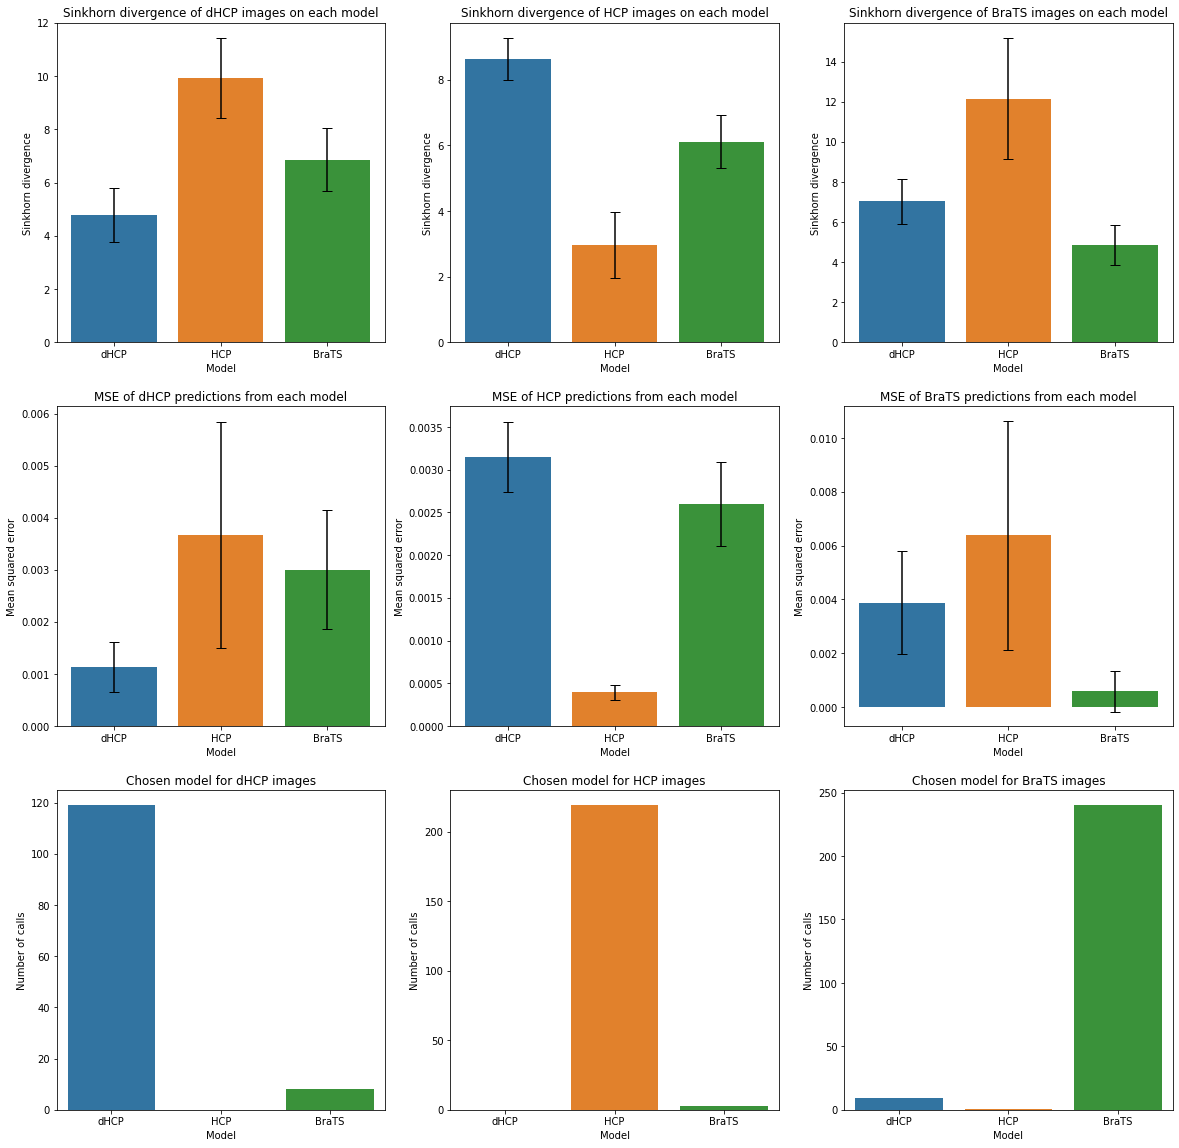

In [12]:
fig, axes = plt.subplots(3,3,figsize=(20,20))

sns.barplot(x=['dHCP','HCP','BraTS'],y=[div_dhcp_dataset[:,0].mean(),div_dhcp_dataset[:,1].mean(),div_dhcp_dataset[:,2].mean()],ax=axes[0,0])
axes[0,0].errorbar(x=[0,1,2],y=[div_dhcp_dataset[:,0].mean(),div_dhcp_dataset[:,1].mean(),div_dhcp_dataset[:,2].mean()],yerr=[div_dhcp_dataset[:,0].std(),div_dhcp_dataset[:,1].std(),div_dhcp_dataset[:,2].std()],fmt='none',ecolor='black',capsize=5)
axes[0,0].set_title('Sinkhorn divergence of dHCP images on each model')
axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Sinkhorn divergence')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[div_hcp_dataset[:,0].mean(),div_hcp_dataset[:,1].mean(),div_hcp_dataset[:,2].mean()],ax=axes[0,1])
axes[0,1].errorbar(x=[0,1,2],y=[div_hcp_dataset[:,0].mean(),div_hcp_dataset[:,1].mean(),div_hcp_dataset[:,2].mean()],yerr=[div_hcp_dataset[:,0].std(),div_hcp_dataset[:,1].std(),div_hcp_dataset[:,2].std()],fmt='none',ecolor='black',capsize=5)
axes[0,1].set_title('Sinkhorn divergence of HCP images on each model')
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('Sinkhorn divergence')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[div_brats_dataset[:,0].mean(),div_brats_dataset[:,1].mean(),div_brats_dataset[:,2].mean()],ax=axes[0,2])
axes[0,2].errorbar(x=[0,1,2],y=[div_brats_dataset[:,0].mean(),div_brats_dataset[:,1].mean(),div_brats_dataset[:,2].mean()],yerr=[div_brats_dataset[:,0].std(),div_brats_dataset[:,1].std(),div_brats_dataset[:,2].std()],fmt='none',ecolor='black',capsize=5)
axes[0,2].set_title('Sinkhorn divergence of BraTS images on each model')
axes[0,2].set_xlabel('Model')
axes[0,2].set_ylabel('Sinkhorn divergence')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[mse_dhcp_dataset[:,0].mean(),mse_dhcp_dataset[:,1].mean(),mse_dhcp_dataset[:,2].mean()],ax=axes[1,0])
axes[1,0].errorbar(x=[0,1,2],y=[mse_dhcp_dataset[:,0].mean(),mse_dhcp_dataset[:,1].mean(),mse_dhcp_dataset[:,2].mean()],yerr=[mse_dhcp_dataset[:,0].std(),mse_dhcp_dataset[:,1].std(),mse_dhcp_dataset[:,2].std()],fmt='none',ecolor='black',capsize=5)
axes[1,0].set_title('MSE of dHCP predictions from each model')
axes[1,0].set_xlabel('Model')
axes[1,0].set_ylabel('Mean squared error')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[mse_hcp_dataset[:,0].mean(),mse_hcp_dataset[:,1].mean(),mse_hcp_dataset[:,2].mean()],ax=axes[1,1])
axes[1,1].errorbar(x=[0,1,2],y=[mse_hcp_dataset[:,0].mean(),mse_hcp_dataset[:,1].mean(),mse_hcp_dataset[:,2].mean()],yerr=[mse_hcp_dataset[:,0].std(),mse_hcp_dataset[:,1].std(),mse_hcp_dataset[:,2].std()],fmt='none',ecolor='black',capsize=5)
axes[1,1].set_title('MSE of HCP predictions from each model')
axes[1,1].set_xlabel('Model')
axes[1,1].set_ylabel('Mean squared error')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[mse_brats_dataset[:,0].mean(),mse_brats_dataset[:,1].mean(),mse_brats_dataset[:,2].mean()],ax=axes[1,2])
axes[1,2].errorbar(x=[0,1,2],y=[mse_brats_dataset[:,0].mean(),mse_brats_dataset[:,1].mean(),mse_brats_dataset[:,2].mean()],yerr=[mse_brats_dataset[:,0].std(),mse_brats_dataset[:,1].std(),mse_brats_dataset[:,2].std()],fmt='none',ecolor='black',capsize=5)
axes[1,2].set_title('MSE of BraTS predictions from each model')
axes[1,2].set_xlabel('Model')
axes[1,2].set_ylabel('Mean squared error')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[calls_dhcp_dataset[0],calls_dhcp_dataset[1],calls_dhcp_dataset[2]],ax=axes[2,0])
axes[2,0].set_title('Chosen model for dHCP images')
axes[2,0].set_xlabel('Model')
axes[2,0].set_ylabel('Number of calls')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[calls_hcp_dataset[0],calls_hcp_dataset[1],calls_hcp_dataset[2]],ax=axes[2,1])
axes[2,1].set_title('Chosen model for HCP images')
axes[2,1].set_xlabel('Model')
axes[2,1].set_ylabel('Number of calls')

sns.barplot(x=['dHCP','HCP','BraTS'],y=[calls_brats_dataset[0],calls_brats_dataset[1],calls_brats_dataset[2]],ax=axes[2,2])
axes[2,2].set_title('Chosen model for BraTS images')
axes[2,2].set_xlabel('Model')
axes[2,2].set_ylabel('Number of calls')


# Inference Example

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

### dHCP Model

In [20]:
def get_inference_example(model, im, gt, save_output = False, save_prefix = ''):
    if isinstance(im, np.ndarray):
        im = torch.from_numpy(im).unsqueeze(0).to(device = 'cuda')
        gt = torch.from_numpy(gt).unsqueeze(0).to(device = 'cuda')
    elif isinstance(im, torch.Tensor):
        im = im.to(device = 'cuda')
        gt = gt.to(device = 'cuda')
    pred = model(im)
    mse = F.mse_loss(pred,gt).item()
    shape = im.shape[2:]

    pred = pred.cpu().detach().numpy()[0,0]
    im = im.cpu().detach().numpy()[0,0]
    gt = gt.cpu().detach().numpy()[0,0]
    # Normalize with lowest 1% and highest value
    im = (im - np.percentile(im,1))/(im.max()-np.percentile(im,1)) * 255
    gt = (gt - np.percentile(gt,1))/(gt.max()-np.percentile(gt,1)) * 255
    pred = (pred - np.percentile(pred,1))/(pred.max()-np.percentile(pred,1)) * 255
    # Generate error map
    err = np.sqrt((pred-gt)**2)
    fig, axes = plt.subplots(4,3,figsize=(8,12))
    fig.suptitle(f'Example of inference {save_prefix}, MSE = {str(mse)}')
    axes[0,0].imshow(im[shape[0]//2,:,:],cmap='gray')
    axes[0,0].set_title('Input image (sagittal)')
    axes[0,0].axis('off')
    axes[0,1].imshow(im[:,shape[1]//2,:],cmap='gray')
    axes[0,1].set_title('Input image (coronal)')
    axes[0,1].axis('off')
    axes[0,2].imshow(im[:,:,shape[2]//2],cmap='gray')
    axes[0,2].set_title('Input image (axial)')
    axes[0,2].axis('off')
    axes[1,0].imshow(pred[shape[0]//2,:,:],cmap='gray')
    axes[1,0].set_title('Prediction (sagittal)')
    axes[1,0].axis('off')
    axes[1,1].imshow(pred[:,shape[1]//2,:],cmap='gray')
    axes[1,1].set_title('Prediction (coronal)')
    axes[1,1].axis('off')
    axes[1,2].imshow(pred[:,:,shape[2]//2],cmap='gray')
    axes[1,2].set_title('Prediction (axial)')
    axes[1,2].axis('off')
    axes[2,0].imshow(gt[shape[0]//2,:,:],cmap='gray')
    axes[2,0].set_title('Ground truth (sagittal)')
    axes[2,0].axis('off')
    axes[2,1].imshow(gt[:,shape[1]//2,:],cmap='gray')
    axes[2,1].set_title('Ground truth (coronal)')
    axes[2,1].axis('off')
    axes[2,2].imshow(gt[:,:,shape[2]//2],cmap='gray')
    axes[2,2].set_title('Ground truth (axial)')
    axes[2,2].axis('off')
    axes[3,0].imshow(err[shape[0]//2,:,:],cmap='jet',vmin=0,vmax=80)
    axes[3,0].set_title('Error map (sagittal)')
    axes[3,0].axis('off')
    axes[3,1].imshow(err[:,shape[1]//2,:],cmap='jet',vmin=0,vmax=80)
    axes[3,1].set_title('Error map (coronal)')
    axes[3,1].axis('off')
    axes[3,2].imshow(err[:,:,shape[2]//2],cmap='jet',vmin=0,vmax=80)
    axes[3,2].set_title('Error map (axial)')
    axes[3,2].axis('off')
    plt.tight_layout()

    if save_output:
        fpath = os.path.join(os.getcwd(),'figures',save_prefix)
        if not os.path.exists(fpath):
            os.makedirs(fpath)
        plt.savefig(os.path.join(fpath,'inference_example.png'),dpi=600)
        Image.fromarray(im[shape[0]//2,:,:].astype(np.uint8)).save(os.path.join(fpath,'input_image_sagittal.png'))
        Image.fromarray(im[:,shape[1]//2,:].astype(np.uint8)).save(os.path.join(fpath,'input_image_coronal.png'))
        Image.fromarray(im[:,:,shape[2]//2].astype(np.uint8)).save(os.path.join(fpath,'input_image_axial.png'))
        Image.fromarray(gt[shape[0]//2,:,:].astype(np.uint8)).save(os.path.join(fpath,'ground_truth_sagittal.png'))
        Image.fromarray(gt[:,shape[1]//2,:].astype(np.uint8)).save(os.path.join(fpath,'ground_truth_coronal.png'))
        Image.fromarray(gt[:,:,shape[2]//2].astype(np.uint8)).save(os.path.join(fpath,'ground_truth_axial.png'))
        Image.fromarray(pred[shape[0]//2,:,:].astype(np.uint8)).save(os.path.join(fpath,'prediction_sagittal.png'))
        # Color mapping
        cmap = plt.get_cmap('jet')
        norm_err = plt.Normalize(0,80)
        err_sag = cmap(norm_err(err[shape[0]//2,:,:]))
        err_cor = cmap(norm_err(err[:,shape[1]//2,:]))
        err_ax = cmap(norm_err(err[:,:,shape[2]//2]))
        plt.figure()
        Image.fromarray((err_sag*255).astype(np.uint8)).save(os.path.join(fpath,'error_map_sagittal.png'))
        Image.fromarray((err_cor*255).astype(np.uint8)).save(os.path.join(fpath,'error_map_coronal.png'))
        Image.fromarray((err_ax*255).astype(np.uint8)).save(os.path.join(fpath,'error_map_axial.png'))

        
    plt.show()

    

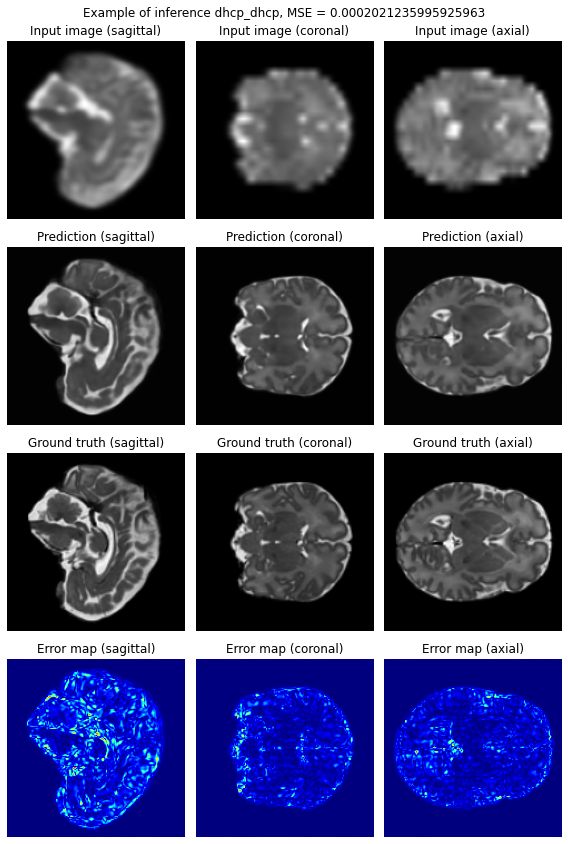

<Figure size 432x288 with 0 Axes>

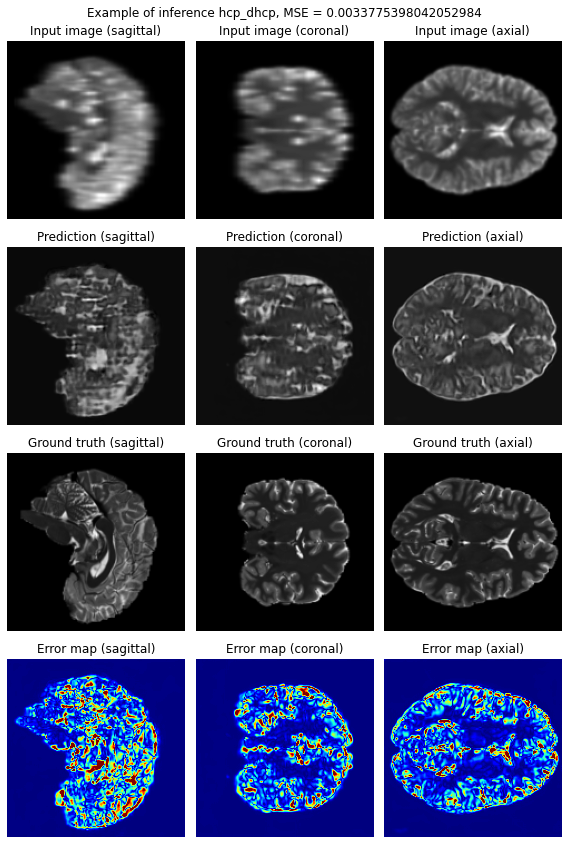

<Figure size 432x288 with 0 Axes>

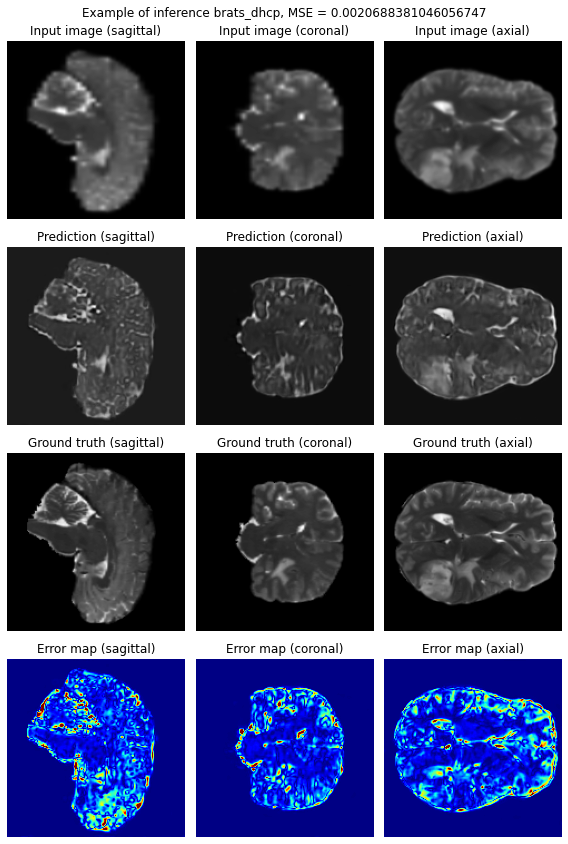

<Figure size 432x288 with 0 Axes>

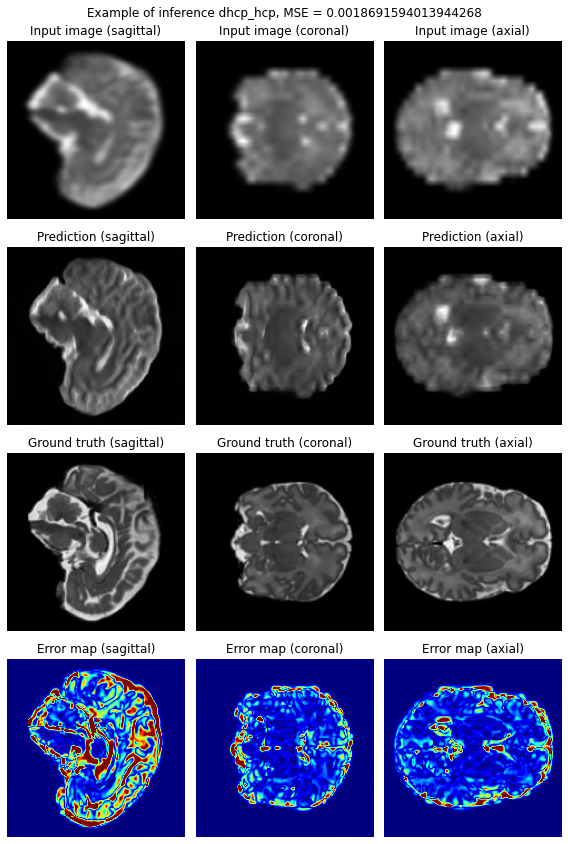

<Figure size 432x288 with 0 Axes>

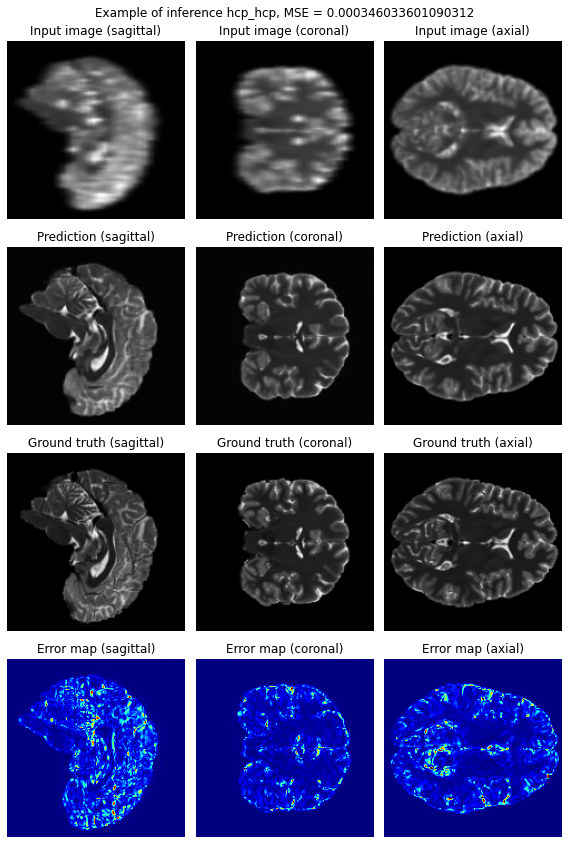

<Figure size 432x288 with 0 Axes>

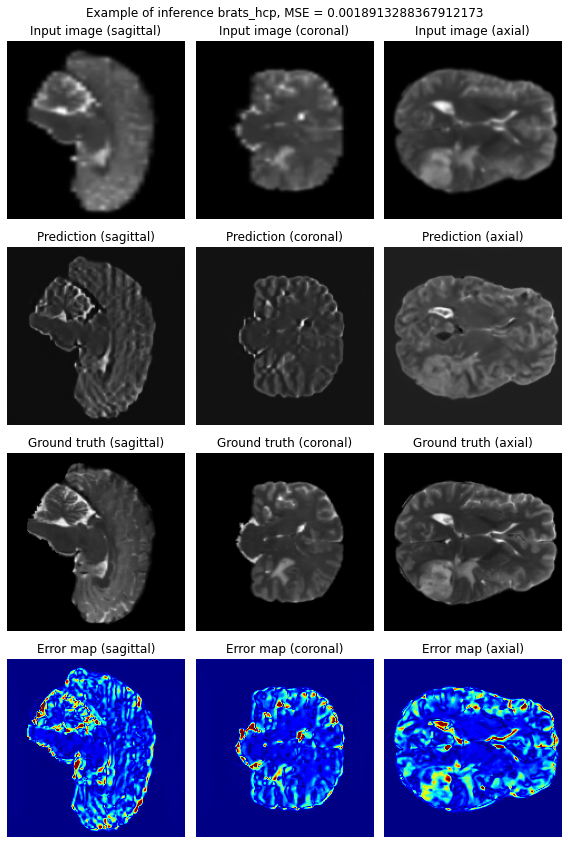

<Figure size 432x288 with 0 Axes>

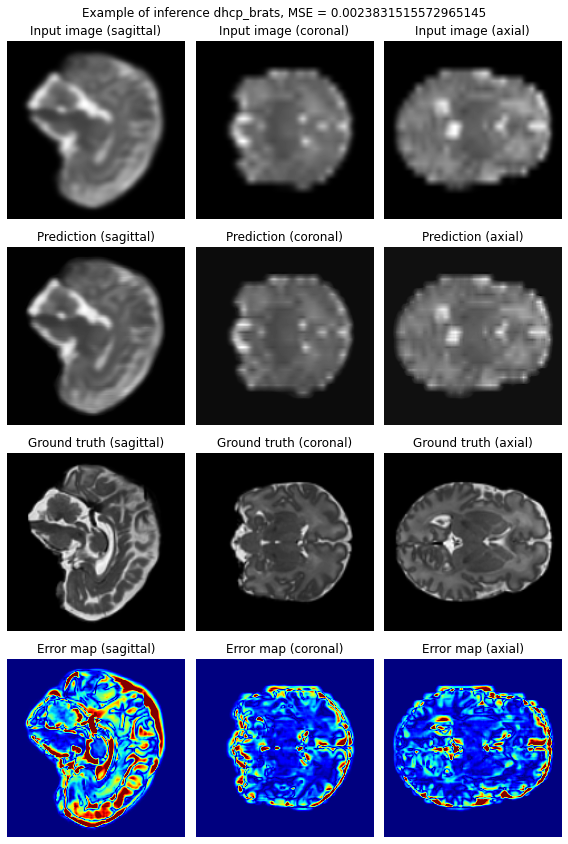

<Figure size 432x288 with 0 Axes>

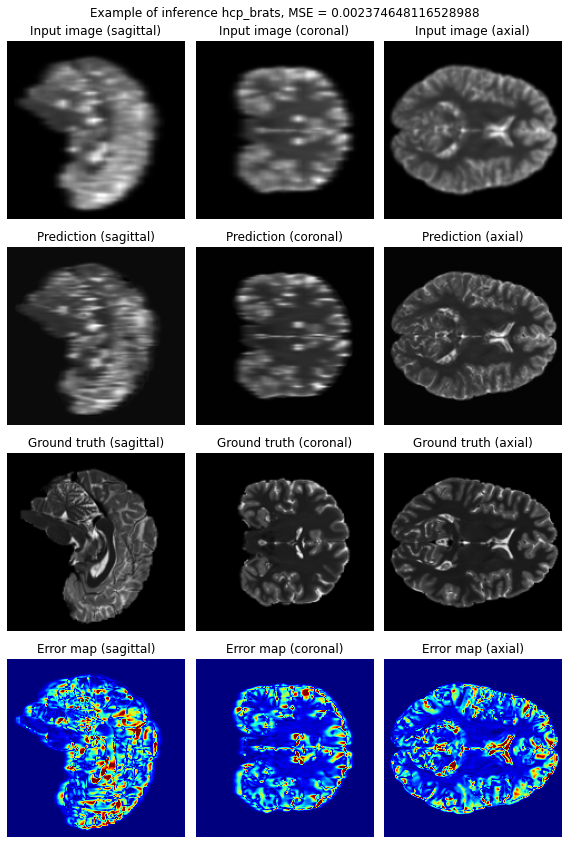

<Figure size 432x288 with 0 Axes>

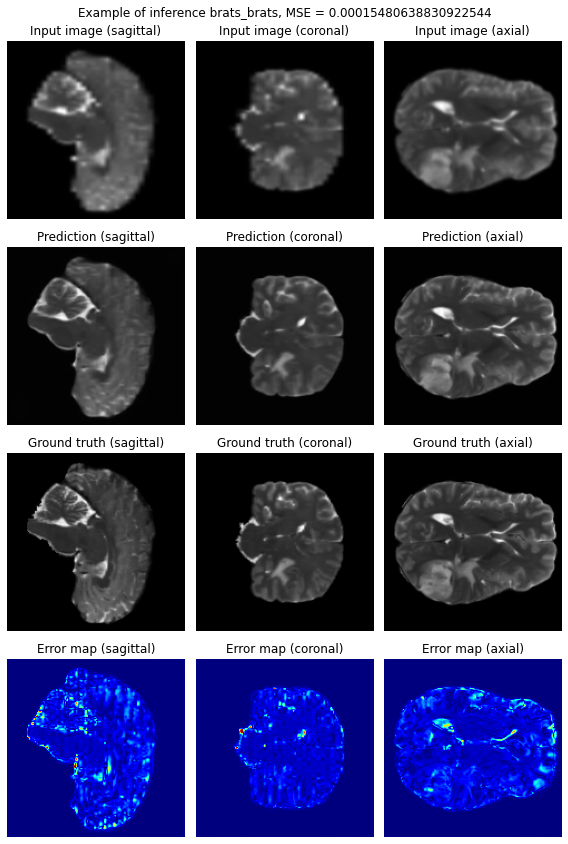

<Figure size 432x288 with 0 Axes>

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(1, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
     

In [22]:
# Inference with dHCP model
model_dhcp.to(device = 'cuda')
im,gt = dhcp_val_loader.dataset.__getitem__(0)
get_inference_example(model_dhcp,im,gt,save_output=True,save_prefix='dhcp_dhcp')
im,gt = hcp_val_loader.dataset.__getitem__(0)
get_inference_example(model_dhcp,im,gt,save_output=True,save_prefix='hcp_dhcp')
im,gt = brats_val_loader.dataset.__getitem__(0)
get_inference_example(model_dhcp,im,gt,save_output=True,save_prefix='brats_dhcp')
model_dhcp.to(device = 'cpu')

# Inference with HCP model
model_hcp.to(device = 'cuda')
im,gt = dhcp_val_loader.dataset.__getitem__(0)
get_inference_example(model_hcp,im,gt,save_output=True,save_prefix='dhcp_hcp')
im,gt = hcp_val_loader.dataset.__getitem__(0)
get_inference_example(model_hcp,im,gt,save_output=True,save_prefix='hcp_hcp')
im,gt = brats_val_loader.dataset.__getitem__(0)
get_inference_example(model_hcp,im,gt,save_output=True,save_prefix='brats_hcp')
model_hcp.to(device = 'cpu')

# Inference with BraTS model
model_brats.to(device = 'cuda')
im,gt = dhcp_val_loader.dataset.__getitem__(0)
get_inference_example(model_brats,im,gt,save_output=True,save_prefix='dhcp_brats')
im,gt = hcp_val_loader.dataset.__getitem__(0)
get_inference_example(model_brats,im,gt,save_output=True,save_prefix='hcp_brats')
im,gt = brats_val_loader.dataset.__getitem__(0)
get_inference_example(model_brats,im,gt,save_output=True,save_prefix='brats_brats')
model_brats.to(device = 'cpu')


# Collect MSE in tumor area

In [ ]:
img,gt = iter(dhcp_val_loader).next()
img = img.cuda()
with torch.no_grad():
    pred = model_dhcp(img)
    pred_bad = model_hcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())
im_array = img[0,0].detach().cpu().numpy()
im_pred_array = pred[0,0].detach().cpu().numpy()
im_gt_array = gt[0,0].detach().cpu().numpy()
im_pred_bad_array = pred_bad[0,0].detach().cpu().numpy()
# Normalize with lowest 1% and highest value
im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
im_gt_array = (im_gt_array - np.percentile(im_gt_array,1))/(im_gt_array.max()-np.percentile(im_gt_array,1))
im_pred_bad_array = (im_pred_bad_array - np.percentile(im_pred_bad_array,1))/(im_pred_bad_array.max()-np.percentile(im_pred_bad_array,1))
im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
im_gt_sag = Image.fromarray(im_gt_array[im_gt_array.shape[0]//2,:,:]*255).convert('L')
im_gt_cor = Image.fromarray(im_gt_array[:,im_gt_array.shape[1]//2,:]*255).convert('L')
im_gt_ax = Image.fromarray(im_gt_array[:,:,im_gt_array.shape[2]//2]*255).convert('L')
im_pred_bad_sag = Image.fromarray(im_pred_bad_array[im_pred_bad_array.shape[0]//2,:,:]*255).convert('L')
im_pred_bad_cor = Image.fromarray(im_pred_bad_array[:,im_pred_bad_array.shape[1]//2,:]*255).convert('L')
im_pred_bad_ax = Image.fromarray(im_pred_bad_array[:,:,im_pred_bad_array.shape[2]//2]*255).convert('L')
im_sag.save('figures/outputs/dHCP_Model/sag.png')
im_cor.save('figures/outputs/dHCP_Model/cor.png')
im_ax.save('figures/outputs/dHCP_Model/ax.png')
im_pred_sag.save('figures/outputs/dHCP_Model/pred_sag.png')
im_pred_cor.save('figures/outputs/dHCP_Model/pred_cor.png')
im_pred_ax.save('figures/outputs/dHCP_Model/pred_ax.png')
im_gt_sag.save('figures/outputs/dHCP_Model/gt_sag.png')
im_gt_cor.save('figures/outputs/dHCP_Model/gt_cor.png')
im_gt_ax.save('figures/outputs/dHCP_Model/gt_ax.png')
im_pred_bad_sag.save('figures/outputs/dHCP_Model/pred_bad_sag.png')
im_pred_bad_cor.save('figures/outputs/dHCP_Model/pred_bad_cor.png')
im_pred_bad_ax.save('figures/outputs/dHCP_Model/pred_bad_ax.png')

### HCP Model

In [ ]:
img,gt = iter(hcp_val_loader).next()
img = img.cuda()
with torch.no_grad():
    pred = model_hcp(img)
    pred_bad = model_dhcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())
im_pred_array = pred[0,0].detach().cpu().numpy()
im_gt_array = gt[0,0].detach().cpu().numpy()
im_pred_bad_array = pred_bad[0,0].detach().cpu().numpy()
# Normalize with lowest 1% and highest value
im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
im_gt_array = (im_gt_array - np.percentile(im_gt_array,1))/(im_gt_array.max()-np.percentile(im_gt_array,1))
im_pred_bad_array = (im_pred_bad_array - np.percentile(im_pred_bad_array,1))/(im_pred_bad_array.max()-np.percentile(im_pred_bad_array,1))
im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
im_gt_sag = Image.fromarray(im_gt_array[im_gt_array.shape[0]//2,:,:]*255).convert('L')
im_gt_cor = Image.fromarray(im_gt_array[:,im_gt_array.shape[1]//2,:]*255).convert('L')
im_gt_ax = Image.fromarray(im_gt_array[:,:,im_gt_array.shape[2]//2]*255).convert('L')
im_pred_bad_sag = Image.fromarray(im_pred_bad_array[im_pred_bad_array.shape[0]//2,:,:]*255).convert('L')
im_pred_bad_cor = Image.fromarray(im_pred_bad_array[:,im_pred_bad_array.shape[1]//2,:]*255).convert('L')
im_pred_bad_ax = Image.fromarray(im_pred_bad_array[:,:,im_pred_bad_array.shape[2]//2]*255).convert('L')
im_sag.save('figures/outputs/HCP_Model/sag.png')
im_cor.save('figures/outputs/HCP_Model/cor.png')
im_ax.save('figures/outputs/HCP_Model/ax.png')
im_pred_sag.save('figures/outputs/HCP_Model/pred_sag.png')
im_pred_cor.save('figures/outputs/HCP_Model/pred_cor.png')
im_pred_ax.save('figures/outputs/HCP_Model/pred_ax.png')
im_gt_sag.save('figures/outputs/HCP_Model/gt_sag.png')
im_gt_cor.save('figures/outputs/HCP_Model/gt_cor.png')
im_gt_ax.save('figures/outputs/HCP_Model/gt_ax.png')
im_pred_bad_sag.save('figures/outputs/HCP_Model/pred_bad_sag.png')
im_pred_bad_cor.save('figures/outputs/HCP_Model/pred_bad_cor.png')
im_pred_bad_ax.save('figures/outputs/HCP_Model/pred_bad_ax.png')


### BraTS Model

In [ ]:
img,gt = iter(brats_test_loader).next()   
img = img.cuda()
with torch.no_grad():
    pred = model_brats(img)
    pred_bad = model_hcp(img)
    pred_worse = model_dhcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_worse[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())
im_array = img[0,0].detach().cpu().numpy()
im_pred_array = pred[0,0].detach().cpu().numpy()
im_gt_array = gt[0,0].detach().cpu().numpy()
im_pred_bad_array = pred_bad[0,0].detach().cpu().numpy()
im_pred_worse_array = pred_worse[0,0].detach().cpu().numpy()
# Normalize with lowest 1% and highest value
im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
im_gt_array = (im_gt_array - np.percentile(im_gt_array,1))/(im_gt_array.max()-np.percentile(im_gt_array,1))
im_pred_bad_array = (im_pred_bad_array - np.percentile(im_pred_bad_array,1))/(im_pred_bad_array.max()-np.percentile(im_pred_bad_array,1))
im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
im_gt_sag = Image.fromarray(im_gt_array[im_gt_array.shape[0]//2,:,:]*255).convert('L')
im_gt_cor = Image.fromarray(im_gt_array[:,im_gt_array.shape[1]//2,:]*255).convert('L')
im_gt_ax = Image.fromarray(im_gt_array[:,:,im_gt_array.shape[2]//2]*255).convert('L')
im_pred_bad_sag = Image.fromarray(im_pred_bad_array[im_pred_bad_array.shape[0]//2,:,:]*255).convert('L')
im_pred_bad_cor = Image.fromarray(im_pred_bad_array[:,im_pred_bad_array.shape[1]//2,:]*255).convert('L')
im_pred_bad_ax = Image.fromarray(im_pred_bad_array[:,:,im_pred_bad_array.shape[2]//2]*255).convert('L')
im_pred_worse_sag = Image.fromarray(im_pred_worse_array[im_pred_worse_array.shape[0]//2,:,:]*255).convert('L')
im_pred_worse_cor = Image.fromarray(im_pred_worse_array[:,im_pred_worse_array.shape[1]//2,:]*255).convert('L')
im_pred_worse_ax = Image.fromarray(im_pred_worse_array[:,:,im_pred_worse_array.shape[2]//2]*255).convert('L')
im_sag.save('figures/outputs/BraTS_Model/sag.png')
im_cor.save('figures/outputs/BraTS_Model/cor.png')
im_ax.save('figures/outputs/BraTS_Model/ax.png')
im_pred_sag.save('figures/outputs/BraTS_Model/pred_sag.png')
im_pred_cor.save('figures/outputs/BraTS_Model/pred_cor.png')
im_pred_ax.save('figures/outputs/BraTS_Model/pred_ax.png')
im_gt_sag.save('figures/outputs/BraTS_Model/gt_sag.png')
im_gt_cor.save('figures/outputs/BraTS_Model/gt_cor.png')
im_gt_ax.save('figures/outputs/BraTS_Model/gt_ax.png')
im_pred_bad_sag.save('figures/outputs/BraTS_Model/pred_bad_sag.png')
im_pred_bad_cor.save('figures/outputs/BraTS_Model/pred_bad_cor.png')
im_pred_bad_ax.save('figures/outputs/BraTS_Model/pred_bad_ax.png')
im_pred_worse_sag.save('figures/outputs/BraTS_Model/pred_worse_sag.png')
im_pred_worse_cor.save('figures/outputs/BraTS_Model/pred_worse_cor.png')
im_pred_worse_ax.save('figures/outputs/BraTS_Model/pred_worse_ax.png')

# Degraded/SR BraTS preparation

In [ ]:
data_dir = '/media/hdd/BraTS2020_lores'
list_dir = glob.glob(op.join(data_dir, '*'))
list_dir.sort()
list_basenames_ = [op.basename(x) for x in list_dir]
list_basenames = [x for x in list_basenames_ if x.endswith('_t2.nii.gz')]
list_images = [op.join(data_dir,x,x+'_t2.nii.gz') for x in list_basenames]
num_samples = len(list_dir)
spacing = [1.5,1.5,5.0]
spacing = np.array(spacing)


In [ ]:
for img in list_images:
    subject = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    subject_original = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    spacing_ = subject.image_t1.spacing
    size_ = subject.image_t1.data.shape[1:]
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.Resample(spacing),
        tio.transforms.Resample((1.,1.,1.)),
        tio.transforms.RandomGamma((0.2,0.2))
    ])
    subject = transform_1(subject)
    edge_max = max(subject.image_t1.data.shape)
    padding = ((edge_max - subject.image_t1.data.shape[1]) // 2, 
                (edge_max - subject.image_t1.data.shape[2]) // 2,
                    (edge_max - subject.image_t1.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)

    transform_inv = tio.Compose([
        tio.transforms.Resample(spacing_),
        tio.transforms.CropOrPad(size_),
    ])
    subject = transform_inv(subject)
    # save
    subject.image_t1.save(img)

In [ ]:
data_dir = '/media/hdd/BraTS2020_SR'
list_dir = glob.glob(op.join(data_dir, '*'))
list_dir.sort()
list_basenames_ = [op.basename(x) for x in list_dir]
list_basenames = [x for x in list_basenames_ if x.startswith('BraTS20_Training_')]
list_images = [op.join(data_dir,x,x+'_t2.nii.gz') for x in list_basenames]
num_samples = len(list_dir)
spacing = [1.5,1.5,5.0]
spacing = np.array(spacing)

In [ ]:
list_images

In [ ]:
for img in tqdm(list_images):
    subject = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    subject_original = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    spacing_ = subject.image_t1.spacing
    size_ = subject.image_t1.data.shape[1:]
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.Resample(spacing),
        tio.transforms.Resample((1.,1.,1.)),
        tio.transforms.RandomGamma((0.2,0.2))
    ])
    subject = transform_1(subject)
    edge_max = max(subject.image_t1.data.shape)
    padding = ((edge_max - subject.image_t1.data.shape[1]) // 2, 
                (edge_max - subject.image_t1.data.shape[2]) // 2,
                    (edge_max - subject.image_t1.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.image_t1.data.unsqueeze(0).cuda()
    subject.image_t1.set_data(model_brats(image_tensor).squeeze(0).cpu().detach().numpy())
    transform_inv = tio.Compose([
        tio.transforms.Resample(spacing_),
        tio.transforms.CropOrPad(size_),
    ])
    subject = transform_inv(subject)
    # save
    subject.image_t1.save(img)

In [ ]:
# overlay two images
im_array = subject.image_t1.data
im_original_array = subject_original.image_t1.data
print(im_array.shape)
print(im_original_array.shape)
im_array = im_array[0,:,:,:]
im_original_array = im_original_array[0,:,:,:]
im_array = im_array[im_array.shape[0]//2,:,:]
im_original_array = im_original_array[im_original_array.shape[0]//2,:,:]
im_array = im_array*255
im_original_array = im_original_array*255
im_array = im_array.numpy().astype(np.uint8)
im_original_array = im_original_array.numpy().astype(np.uint8)
im = Image.fromarray(im_array).convert('L')
im_original = Image.fromarray(im_original_array).convert('L')
im_blended = Image.blend(im, im_original, alpha=0.1)
display(im_original)
display(im)
display(im_blended)

# Model Selector